In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
directory = 'Dillards POS/'
skst_file_path = directory + 'skstinfo.csv'
trans_file_path = directory + 'trans_final.csv'

#sku_file_path = directory + 'skuinfo.csv'
#sku_retail_file_path = directory + 'sku_retail.csv'
clean_sku_file_path = directory + 'sku_final.csv'

In [3]:
def prepare_basket(trans_file_path, skst_file_path):
    ''' function that prepares basket from the transaction table'''
    
    # Transaction table
    trans = pd.read_csv(trans_file_path)
    trans.columns = ['sku', 'storeid', 'register', 'trannum', 'interID', 'saledate', 'stype', 'quantity',
                 'orgprice', 'amt', 'seq', 'mic', 'unkown']
    # Drop all returns
    trans = trans[trans['stype'] == 'P']
    
    # Drop columns irrelevant to basket
    trans.drop(columns=['interID', 'stype', 'mic', 'unkown'], inplace=True)
    
    # skst table
    skst = pd.read_csv(skst_file_path, header = None)
    skst.columns = ['sku', 'storeid', 'cost', 'retail', 'unknown']
    
    # Drop columns irrelevant to basket
    skst.drop(columns = ['unknown'], inplace=True)
    
    # Get non zero mean retail for each sku
    mean_retail = skst.groupby('sku')['retail'].unique().reset_index()
    mean_retail['retail'] = mean_retail['retail'].apply(
        lambda x: sum(x) / len(x) if len(x) > 0 else 0 if len([i for i in x if i != 0]) > 0 else 0
    )
    mean_retail = mean_retail.set_index('sku')
    mean_retail_series = mean_retail['retail']
    
    # Merge transaction and skst
    trans = pd.merge(trans, skst, on=['sku','storeid'], how='left')
    
    # Fill NaN values in 'retail' with the mean retail
    trans['retail'] = trans['retail'].fillna(trans['sku'].map(mean_retail_series))
    # Fill NaN values in 'retail' with the corresponding 'orgprice' values
    trans['retail'] = trans['retail'].fillna(trans['orgprice'])
    
    # Fill NaN values in 'orgprice' with the mean retail
    trans['orgprice'] = trans['orgprice'].fillna(trans['sku'].map(mean_retail_series))
    
    
    # Feature engineering
    
    trans['saledate'] = pd.to_datetime(trans['saledate'])
    # day of week as a number (Monday=0, Sunday=6)
    trans['day_of_week'] = trans['saledate'].dt.dayofweek
    # month as a number
    trans['month'] = trans['saledate'].dt.month
    # Define weekend as Friday (4) to Sunday (6)
    trans['weekend'] = trans['day_of_week'].apply(lambda x: 1 if x >= 4 else 0)
    
    condition_retail_zero = trans['retail'] == 0
    trans.loc[condition_retail_zero, 'retail'] = trans['amt']
    condition_retail_zero = trans['retail'] == 0
    trans.loc[condition_retail_zero, 'retail'] = trans['orgprice']
    
    trans['percent_discount'] = (trans['orgprice'] - trans['retail']) / trans['orgprice']
    condition_retail_greater = trans['retail'] >= trans['orgprice']
    trans.loc[condition_retail_greater, 'percent_discount'] = 0
    condition_retail_zero = trans['orgprice'] <= 0
    trans.loc[condition_retail_zero, 'percent_discount'] = 0
    condition_discount_zero = trans['percent_discount'] < 0
    trans.loc[condition_discount_zero, 'percent_discount'] = 0
    
    
    # final sale defined as > 50% discount
    trans['final_sale'] = np.where(trans['percent_discount']>0.5, 1, 0)
    return trans

In [4]:
basket = prepare_basket(trans_file_path, skst_file_path)
basket.head()

,sku,storeid,register,trannum,saledate,quantity,orgprice,amt,seq,cost,retail,day_of_week,month,weekend,percent_discount,final_sale
0,1658506,9709,80,4600,2004-10-08,1,13.5,13.5,530400071,8.1,13.5,4,10,1,0.0,0
1,1658506,9709,80,4600,2005-04-12,1,13.5,13.5,556900050,8.1,13.5,1,4,0,0.0,0
2,1658506,9709,80,4700,2004-09-18,1,13.5,13.5,908400195,8.1,13.5,5,9,1,0.0,0
3,1658506,9709,80,4800,2005-06-03,1,13.5,13.5,839200063,8.1,13.5,4,6,1,0.0,0
4,1658506,9709,80,4900,2004-10-15,1,13.5,13.5,78400078,8.1,13.5,4,10,1,0.0,0


In [5]:
basket.shape

(111649093, 16)

In [6]:
def join_dataframes(input_df, csv_file_path, columns, join_key = 'sku', how='inner'):
    """
    Joins an input DataFrame with a DataFrame loaded from a CSV file.

    """
    
    columns = columns  + [join_key]
    # Load the second DataFrame from the CSV file
    csv_df = pd.read_csv(csv_file_path)
    csv_df.columns = ['sku', 'deptid', 'classid', 'upc', 'style', 'color', 'size', 'packsize',
                 'vendor', 'brand']

    # Perform the join
    joined_df = pd.merge(input_df, csv_df[columns], on=join_key, how=how)

    return joined_df

In [7]:
#basket = basket.head(10000)

In [8]:
columns = ['brand', 'classid']
joined_df = join_dataframes(basket, clean_sku_file_path, columns)
joined_df.head()

,sku,storeid,register,trannum,saledate,quantity,orgprice,amt,seq,cost,retail,day_of_week,month,weekend,percent_discount,final_sale,brand,classid
0,1658506,9709,80,4600,2004-10-08,1,13.5,13.5,530400071,8.1,13.5,4,10,1,0.0,0,CLINIQUE,007
1,1658506,9709,80,4600,2005-04-12,1,13.5,13.5,556900050,8.1,13.5,1,4,0,0.0,0,CLINIQUE,007
2,1658506,9709,80,4700,2004-09-18,1,13.5,13.5,908400195,8.1,13.5,5,9,1,0.0,0,CLINIQUE,007
3,1658506,9709,80,4800,2005-06-03,1,13.5,13.5,839200063,8.1,13.5,4,6,1,0.0,0,CLINIQUE,007
4,1658506,9709,80,4900,2004-10-15,1,13.5,13.5,78400078,8.1,13.5,4,10,1,0.0,0,CLINIQUE,007


In [9]:
# Filter values between 0.2 and 0.4
filtered_percent_discount = joined_df[(joined_df['percent_discount'] > 0.2) & (joined_df['percent_discount'] < 0.4)]

# Sort by percent_discount in descending order
filtered_percent_discount = filtered_percent_discount.sort_values(by='percent_discount', ascending=False)

# Display the top rows
filtered_percent_discount.head()

,sku,storeid,register,trannum,saledate,quantity,orgprice,amt,seq,cost,retail,day_of_week,month,weekend,percent_discount,final_sale,brand,classid
68651094,7609228,2707,30,1100,2005-07-28,1,368.0,154.56,925700151,182.00,220.8,3,7,0,0.4,0,TAHARI L,004
102880901,797171,6604,50,2600,2005-07-18,1,7.0,4.69,180100023,2.85,4.2,0,7,0,0.4,0,CHRISTY,204
47032940,5577946,2203,550,2700,2005-06-01,1,238.0,238.00,38900038,82.60,142.8,2,6,0,0.4,0,NYGARD,004
47032939,5577946,2109,730,300,2005-07-07,1,238.0,238.00,396800042,82.60,142.8,3,7,0,0.4,0,NYGARD,004
47032938,5577946,1607,560,700,2005-07-31,1,238.0,238.00,567800039,82.60,142.8,6,7,1,0.4,0,NYGARD,004


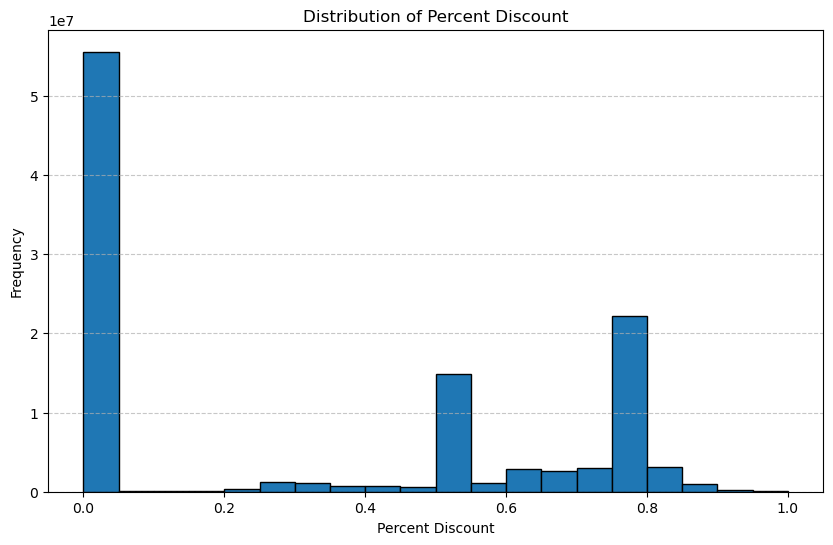

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'joined_df' is your DataFrame
percent_discount = joined_df['percent_discount']

# Filter out non-finite values
valid_percent_discount = percent_discount[np.isfinite(percent_discount)]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(valid_percent_discount, bins=20, edgecolor='black')

plt.xlabel('Percent Discount')
plt.ylabel('Frequency')
plt.title('Distribution of Percent Discount')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [11]:
joined_df.shape

(111649061, 18)

## Basket Prep Linda

In [ ]:
def get_basket(df, items):
    '''list items in a basket'''
    output = df.groupby(['saledate', 'storeid', 'register', 'trannum'])[items].apply(list).reset_index(name='Items')
    return output

In [ ]:
basket = get_basket(joined_df, 'brand')
basket.head()

## Single Out one specific Brand

In [12]:
joined_df.dtypes

sku                          int64
storeid                      int64
register                     int64
trannum                      int64
saledate            datetime64[ns]
quantity                     int64
orgprice                   float64
amt                        float64
seq                          int64
cost                       float64
retail                     float64
day_of_week                  int64
month                        int64
weekend                      int64
percent_discount           float64
final_sale                   int64
brand                       object
classid                     object
dtype: object

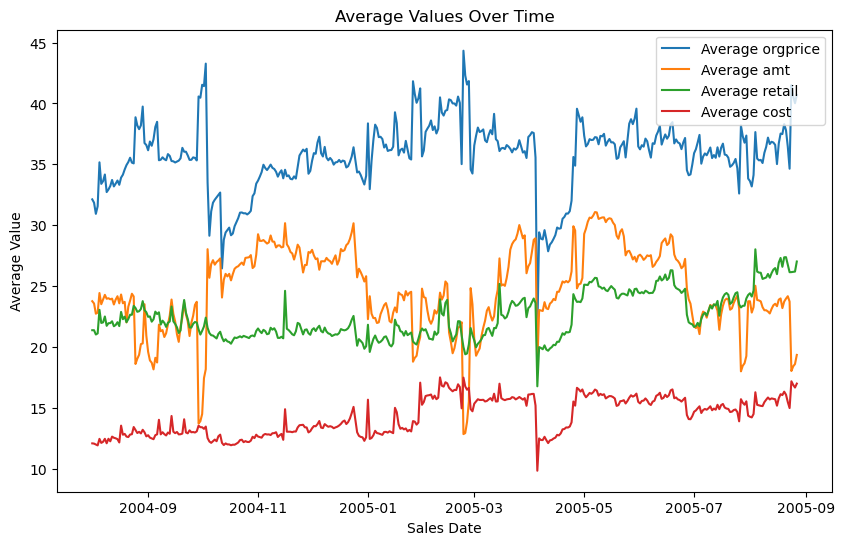

In [13]:
import matplotlib.pyplot as plt
# Step 3: Group by "saledate" and calculate the averages
grouped_df = joined_df.groupby('saledate')[['orgprice', 'amt', 'retail', 'cost']].mean().reset_index()

# Step 4: Plot the line chart
plt.figure(figsize=(10, 6))

for col in ['orgprice', 'amt', 'retail', 'cost']:
    plt.plot(grouped_df['saledate'], grouped_df[col], label=f'Average {col}')

plt.xlabel('Sales Date')
plt.ylabel('Average Value')
plt.title('Average Values Over Time')
plt.legend()
plt.show()

In [14]:
selected_brand = "CHRISTY"
analysis1 = joined_df[joined_df['brand'].str.contains(selected_brand, case=False)]
analysis1.head()

,sku,storeid,register,trannum,saledate,quantity,orgprice,amt,seq,cost,retail,day_of_week,month,weekend,percent_discount,final_sale,brand,classid
50089264,5866397,4109,40,300,2004-10-01,1,30.0,7.5,906000265,NaN,7.5,4,10,1,0.75,1,CHRISTY,001
50089265,5866397,4109,50,1500,2004-09-10,1,30.0,15.0,129000095,NaN,7.5,4,9,1,0.75,1,CHRISTY,001
50089266,5866397,4109,50,2000,2004-10-01,1,30.0,7.5,906200265,NaN,7.5,4,10,1,0.75,1,CHRISTY,001
50089267,5866397,4109,50,2000,2004-10-01,1,30.0,7.5,906300265,NaN,7.5,4,10,1,0.75,1,CHRISTY,001
50089268,5866397,4109,50,3800,2004-10-01,1,30.0,7.5,906100265,NaN,7.5,4,10,1,0.75,1,CHRISTY,001


In [15]:
unique_counts = analysis1.nunique()
print(unique_counts)

sku                    45
storeid               312
register              228
trannum               314
saledate              361
quantity                1
orgprice                6
amt                   181
seq                 37298
cost                    6
retail                 35
day_of_week             7
month                  12
weekend                 2
percent_discount       27
final_sale              2
brand                   1
classid                 2
dtype: int64


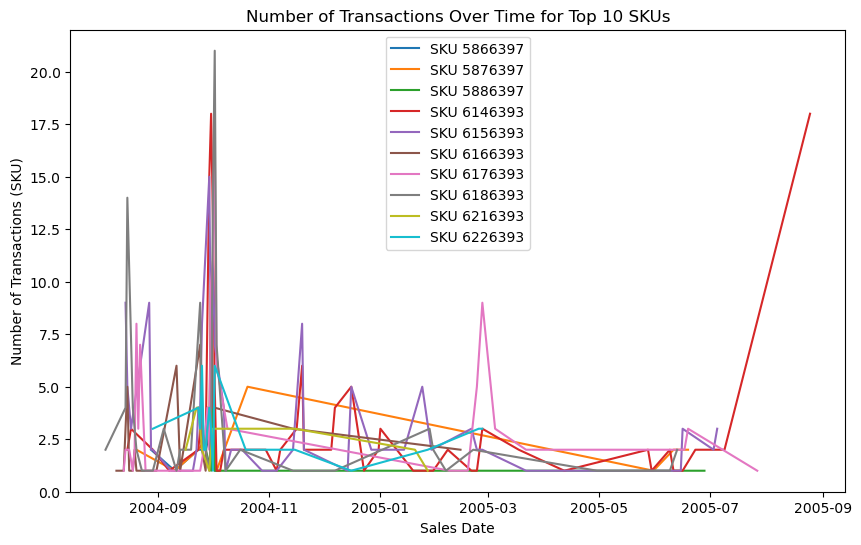

In [16]:
import matplotlib.pyplot as plt

# Step 1: Get the first 10 unique values of the "sku" column
unique_skus = analysis1['sku'].unique()[:10]

# Step 2: Filter the DataFrame based on the first 10 unique values of "sku"
filtered_df = analysis1[analysis1['sku'].isin(unique_skus)]

# Step 3: Group by "sku" and "sales date", calculate the count of transactions (SKU)
grouped_df = filtered_df.groupby(['sku', 'saledate'])['seq'].count().reset_index()
grouped_df = grouped_df.rename(columns={'seq': 'transaction_count'})

# Step 4: Plot the line chart
plt.figure(figsize=(10, 6))

for sku in unique_skus:
    sku_data = grouped_df[grouped_df['sku'] == sku]
    plt.plot(sku_data['saledate'], sku_data['transaction_count'], label=f'SKU {sku}')

plt.xlabel('Sales Date')
plt.ylabel('Number of Transactions (SKU)')
plt.title('Number of Transactions Over Time for Top 10 SKUs')
plt.legend()
plt.show()

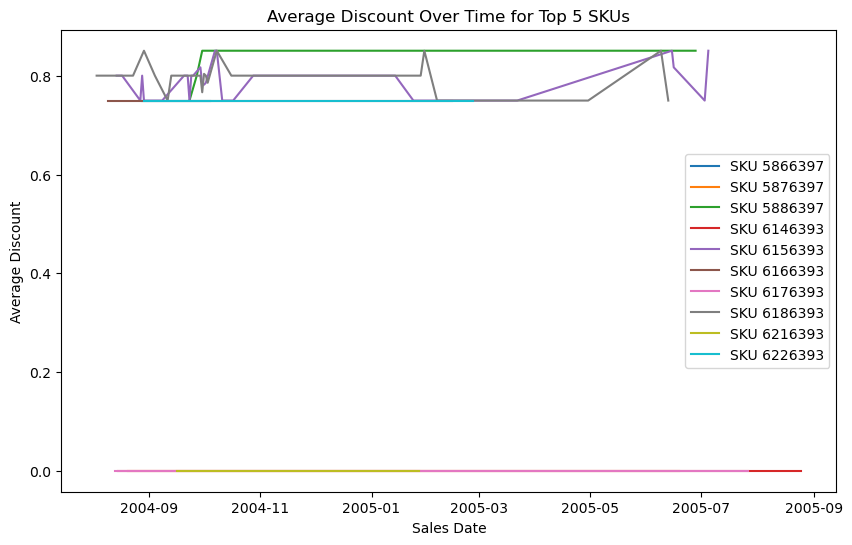

In [17]:
import matplotlib.pyplot as plt

# Step 1: Get the first 5 unique values of the "sku" column
unique_skus = analysis1['sku'].unique()[:10]

# Step 2: Filter the DataFrame based on the first 5 unique values of "sku"
filtered_df = analysis1[analysis1['sku'].isin(unique_skus)]

# Step 3: Group by "sku" and "sales date", calculate the average of "discount"
grouped_df = filtered_df.groupby(['sku', 'saledate'])['percent_discount'].mean().reset_index()

# Step 4: Plot the line chart
plt.figure(figsize=(10, 6))

for sku in unique_skus:
    sku_data = grouped_df[grouped_df['sku'] == sku]
    plt.plot(sku_data['saledate'], sku_data['percent_discount'], label=f'SKU {sku}')

plt.xlabel('Sales Date')
plt.ylabel('Average Discount')
plt.title('Average Discount Over Time for Top 5 SKUs')
plt.legend()
plt.show()

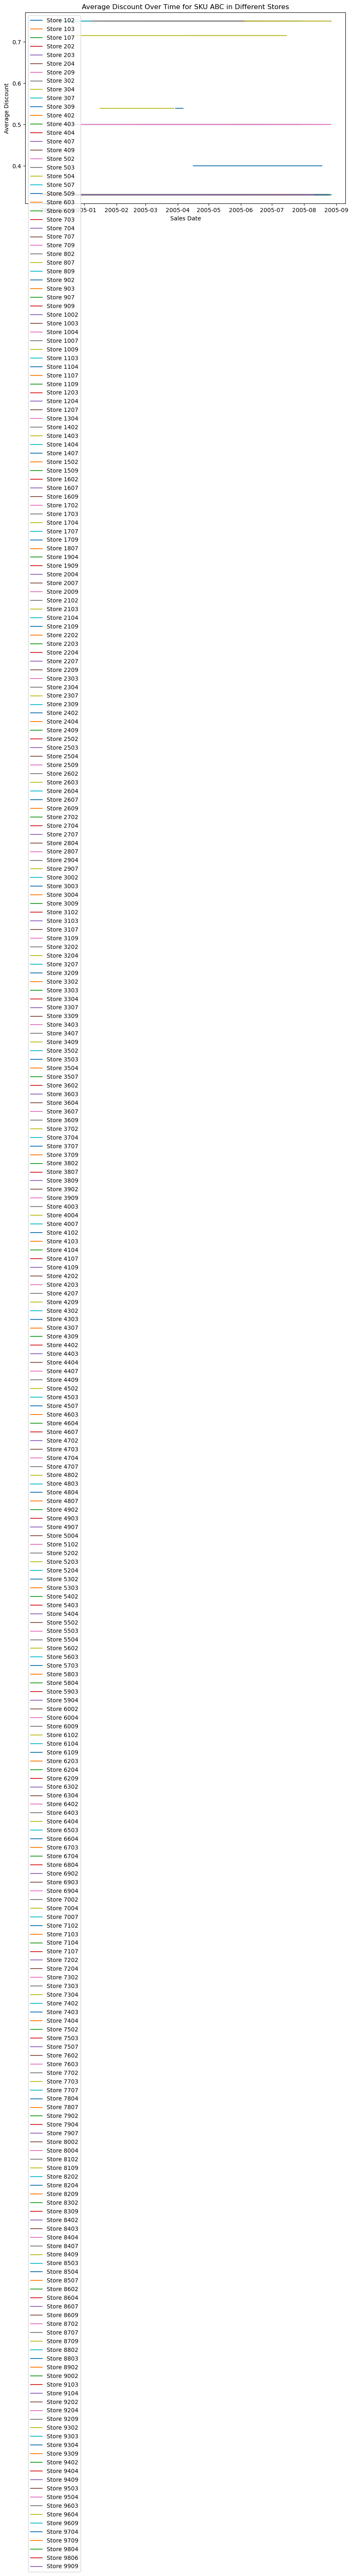

In [18]:
import matplotlib.pyplot as plt

# Step 1: Filter the DataFrame for the specific SKU "ABC"
filtered_df = joined_df[joined_df['sku'] == 797171]

# Step 2: Group by "storeid" and "sales date", calculate the average of "discount"
grouped_df = filtered_df.groupby(['storeid', 'saledate'])['percent_discount'].mean().reset_index()

# Step 3: Plot the line chart
plt.figure(figsize=(10, 6))

for storeid in grouped_df['storeid'].unique():
    store_data = grouped_df[grouped_df['storeid'] == storeid]
    plt.plot(store_data['saledate'], store_data['percent_discount'], label=f'Store {storeid}')

plt.xlabel('Sales Date')
plt.ylabel('Average Discount')
plt.title('Average Discount Over Time for SKU ABC in Different Stores')
plt.legend()
plt.show()

In [19]:
sorted_filtered_df = filtered_df.sort_values(by="percent_discount", ascending = False)
sorted_filtered_df.head()

,sku,storeid,register,trannum,saledate,quantity,orgprice,amt,seq,cost,retail,day_of_week,month,weekend,percent_discount,final_sale,brand,classid
102881096,797171,7507,150,3900,2005-06-17,1,7.0,1.75,946900032,2.85,1.75,4,6,1,0.75,1,CHRISTY,204
102881313,797171,8407,230,3300,2005-07-17,1,7.0,1.75,744100021,2.85,1.75,6,7,1,0.75,1,CHRISTY,204
102881315,797171,8407,230,5600,2005-07-15,1,7.0,1.75,638000034,2.85,1.75,4,7,1,0.75,1,CHRISTY,204
102881316,797171,8407,230,5600,2005-07-15,1,7.0,1.75,638100034,2.85,1.75,4,7,1,0.75,1,CHRISTY,204
102881317,797171,8407,230,5600,2005-07-15,1,7.0,1.75,638200034,2.85,1.75,4,7,1,0.75,1,CHRISTY,204


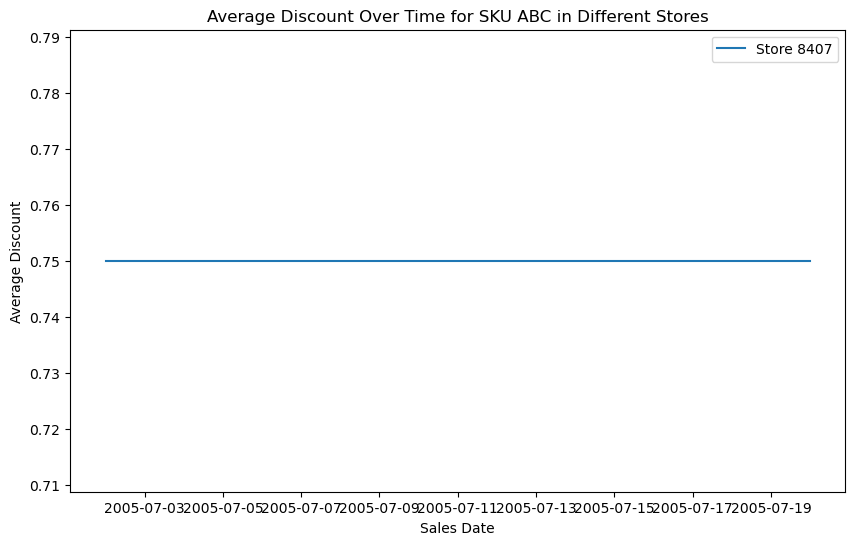

In [20]:
import matplotlib.pyplot as plt

# Step 1: Filter the DataFrame for the specific SKU "ABC"
filtered_df = analysis1[analysis1['sku'] == 797171]
filtered_df = filtered_df[filtered_df['storeid'] == 8407]

# Step 2: Group by "storeid" and "sales date", calculate the average of "discount"
grouped_df = filtered_df.groupby(['storeid', 'saledate'])['percent_discount'].mean().reset_index()

# Step 3: Plot the line chart
plt.figure(figsize=(10, 6))

for storeid in grouped_df['storeid'].unique():
    store_data = grouped_df[grouped_df['storeid'] == storeid]
    plt.plot(store_data['saledate'], store_data['percent_discount'], label=f'Store {storeid}')

plt.xlabel('Sales Date')
plt.ylabel('Average Discount')
plt.title('Average Discount Over Time for SKU ABC in Different Stores')
plt.legend()
plt.show()

In [21]:
sorted_filtered_df = filtered_df.sort_values(by="saledate", ascending = True)
sorted_filtered_df.head()

,sku,storeid,register,trannum,saledate,quantity,orgprice,amt,seq,cost,retail,day_of_week,month,weekend,percent_discount,final_sale,brand,classid
102881306,797171,8407,230,900,2005-07-02,1,7.0,4.69,55700045,2.85,1.75,5,7,1,0.75,1,CHRISTY,204
102881307,797171,8407,230,900,2005-07-02,1,7.0,4.69,55800045,2.85,1.75,5,7,1,0.75,1,CHRISTY,204
102881322,797171,8407,310,3600,2005-07-15,1,7.0,1.75,637900034,2.85,1.75,4,7,1,0.75,1,CHRISTY,204
102881321,797171,8407,310,3600,2005-07-15,1,7.0,1.75,637800034,2.85,1.75,4,7,1,0.75,1,CHRISTY,204
102881320,797171,8407,310,3600,2005-07-15,1,7.0,1.75,637700034,2.85,1.75,4,7,1,0.75,1,CHRISTY,204


In [22]:
filtered_df.describe()

,sku,storeid,register,trannum,quantity,orgprice,amt,seq,cost,retail,day_of_week,month,weekend,percent_discount,final_sale
count,20.0,20.0,20.000000,20.000000,20.0,20.0,20.000000,2.000000e+01,2.000000e+01,20.00,20.000000,20.0,20.000000,20.00,20.0
mean,797171.0,8407.0,279.500000,3370.000000,1.0,7.0,2.044000,5.098900e+08,2.850000e+00,1.75,4.500000,7.0,0.900000,0.75,1.0
std,0.0,0.0,91.102892,2130.752276,0.0,0.0,0.904913,2.015955e+08,9.112518e-16,0.00,1.100239,0.0,0.307794,0.00,0.0
min,797171.0,8407.0,230.000000,700.000000,1.0,7.0,1.750000,5.570004e+07,2.850000e+00,1.75,2.000000,7.0,0.000000,0.75,1.0
25%,797171.0,8407.0,230.000000,1700.000000,1.0,7.0,1.750000,4.525750e+08,2.850000e+00,1.75,4.000000,7.0,1.000000,0.75,1.0
50%,797171.0,8407.0,230.000000,3300.000000,1.0,7.0,1.750000,5.453500e+08,2.850000e+00,1.75,5.000000,7.0,1.000000,0.75,1.0
75%,797171.0,8407.0,310.000000,5525.000000,1.0,7.0,1.750000,6.381250e+08,2.850000e+00,1.75,5.000000,7.0,1.000000,0.75,1.0
max,797171.0,8407.0,480.000000,8400.000000,1.0,7.0,4.690000,7.442000e+08,2.850000e+00,1.75,6.000000,7.0,1.000000,0.75,1.0


In [23]:
filtered_df = filtered_df[filtered_df['saledate'] == "2005-07-16"]
filtered_df.head(50)

,sku,storeid,register,trannum,saledate,quantity,orgprice,amt,seq,cost,retail,day_of_week,month,weekend,percent_discount,final_sale,brand,classid
102881308,797171,8407,230,1700,2005-07-16,1,7.0,1.75,452500045,2.85,1.75,5,7,1,0.75,1,CHRISTY,204
102881309,797171,8407,230,1700,2005-07-16,1,7.0,1.75,452600045,2.85,1.75,5,7,1,0.75,1,CHRISTY,204
102881319,797171,8407,230,8400,2005-07-16,1,7.0,1.75,452700045,2.85,1.75,5,7,1,0.75,1,CHRISTY,204
102881323,797171,8407,480,700,2005-07-16,1,7.0,1.75,452900045,2.85,1.75,5,7,1,0.75,1,CHRISTY,204
102881324,797171,8407,480,700,2005-07-16,1,7.0,1.75,453000045,2.85,1.75,5,7,1,0.75,1,CHRISTY,204
102881325,797171,8407,480,5500,2005-07-16,1,7.0,1.75,452800045,2.85,1.75,5,7,1,0.75,1,CHRISTY,204


In [24]:
filtered_df.shape

(6, 18)

In [25]:
unique_counts = filtered_df.nunique()
print(unique_counts)

sku                 1
storeid             1
register            2
trannum             4
saledate            1
quantity            1
orgprice            1
amt                 1
seq                 6
cost                1
retail              1
day_of_week         1
month               1
weekend             1
percent_discount    1
final_sale          1
brand               1
classid             1
dtype: int64


## Analyze SKUs (how many per day per store)

In [ ]:
# Step 1: Group by "storeid," "sales date," and "sku" and count the number of items sold
grouped_df = joined_df.groupby(['storeid', 'saledate', 'sku']).size().reset_index(name='items_sold')

In [ ]:
# Step 2: Calculate overall sum, number of unique stores, days, and items
overall_sum_items = grouped_df['items_sold'].sum()

In [ ]:
unique_stores = grouped_df['storeid'].nunique()

In [ ]:
unique_days = grouped_df['saledate'].nunique()

In [ ]:
unique_items = grouped_df['sku'].nunique()

In [ ]:
# Step 3: Calculate the average number of items sold per store per day
average_items_sold = overall_sum_items / (unique_stores * unique_days * unique_items)

print(f"The average number of items sold per store per day is: {average_items_sold:.2f}")

In [ ]:
overall_sum_items

In [ ]:
unique_stores

In [ ]:
unique_days

In [ ]:
unique_items

In [ ]:
average_items_sold

## Representation of SKUs in stores

In [26]:
import matplotlib.pyplot as plt

# Assuming 'original_df' is your original DataFrame
sku_store_counts = joined_df.groupby('sku')['storeid'].nunique()

In [27]:
# Display 5 examples of items that are only sold in very few stores
few_stores_skus = sku_store_counts[sku_store_counts < 2].index[:5]
few_stores_skus

Int64Index([20, 69, 73, 107, 133], dtype='int64', name='sku')

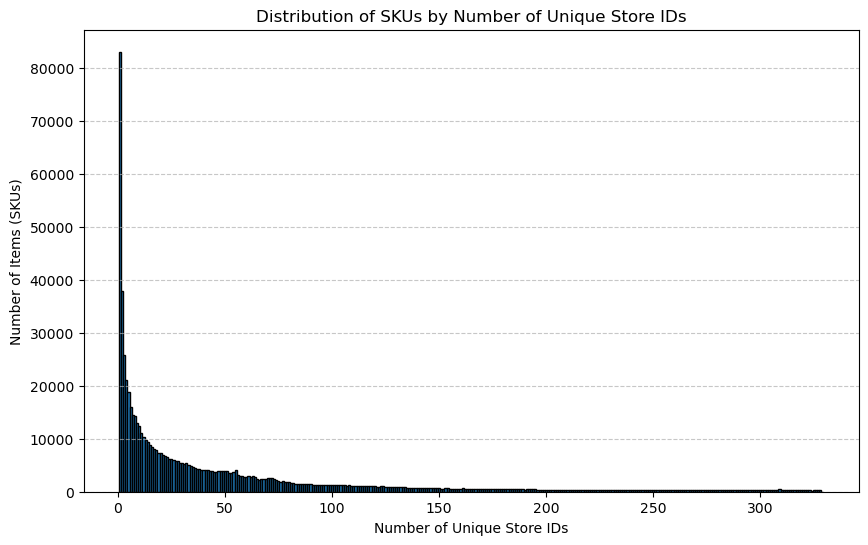

In [28]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(sku_store_counts, bins=range(1, sku_store_counts.max() + 2), edgecolor='black', align='left')

plt.xlabel('Number of Unique Store IDs')
plt.ylabel('Number of Items (SKUs)')
plt.title('Distribution of SKUs by Number of Unique Store IDs')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [29]:
sku_20_df = joined_df[joined_df['sku'] == 20].copy()
sku_20_df.head()

,sku,storeid,register,trannum,saledate,quantity,orgprice,amt,seq,cost,retail,day_of_week,month,weekend,percent_discount,final_sale,brand,classid
94395229,20,3607,80,1600,2005-08-09,1,NaN,19.99,15600000,NaN,NaN,1,8,0,NaN,0,BROWN SH,711


In [30]:
joined_df.shape

(111649061, 18)

In [31]:
import matplotlib.pyplot as plt

item_counts = joined_df.groupby('sku').size()
item_counts.head()

sku
4     26
5     20
8      6
20     1
23     5
dtype: int64

In [32]:
item_counts.shape

(713171,)

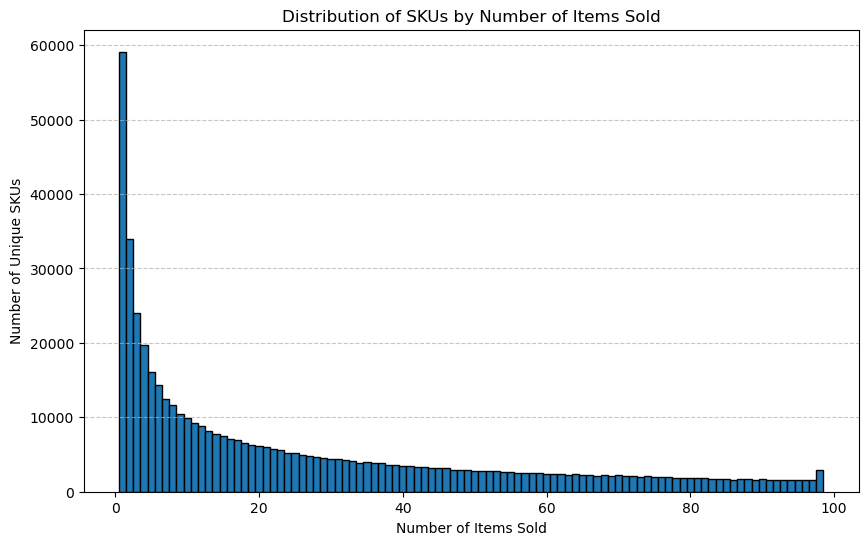

In [33]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
# plt.hist(item_counts, bins=range(1, item_counts.max() + 2), edgecolor='black', align='left')
plt.hist(item_counts, range(1, 100), edgecolor='black', align='left')

plt.xlabel('Number of Items Sold')
plt.ylabel('Number of Unique SKUs')
plt.title('Distribution of SKUs by Number of Items Sold')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

## Analyze Class ID

In [ ]:
# Step 1: Group by "storeid," "sales date," and "sku" and count the number of items sold
grouped_df = joined_df.groupby(['storeid', 'saledate', 'classid']).size().reset_index(name='items_sold')

In [ ]:
# Step 2: Calculate overall sum, number of unique stores, days, and items
overall_sum_items = grouped_df['items_sold'].sum()
overall_sum_items

In [ ]:
unique_stores = grouped_df['storeid'].nunique()
unique_stores

In [ ]:
unique_days = grouped_df['saledate'].nunique()
unique_days

In [ ]:
unique_items = grouped_df['classid'].nunique()
unique_items

In [ ]:
# Step 3: Calculate the average number of items sold per store per day
average_items_sold = overall_sum_items / (unique_stores * unique_days * unique_items)

print(f"The average number of item classes sold per store per day is: {average_items_sold:.2f}")

### classes over stores

In [34]:
import matplotlib.pyplot as plt

# Assuming 'original_df' is your original DataFrame
class_store_counts = joined_df.groupby('classid')['storeid'].count()

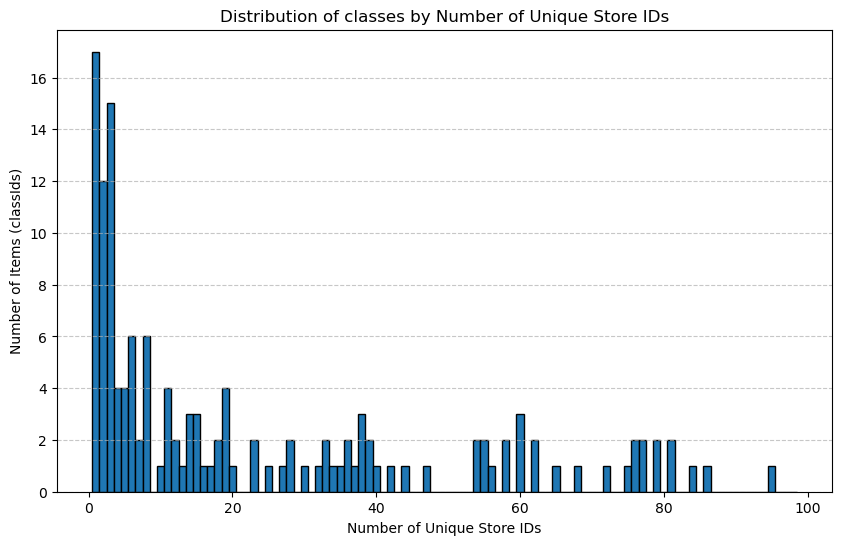

In [35]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(class_store_counts, bins=range(1, 100), edgecolor='black', align='left')

plt.xlabel('Number of Unique Store IDs')
plt.ylabel('Number of Items (classIds)')
plt.title('Distribution of classes by Number of Unique Store IDs')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

### classes analysis

In [36]:
item_counts = joined_df.groupby('classid').size()
item_counts.head()

classid
000           3
001     9017204
002    10115493
003     2702027
004     3550072
dtype: int64

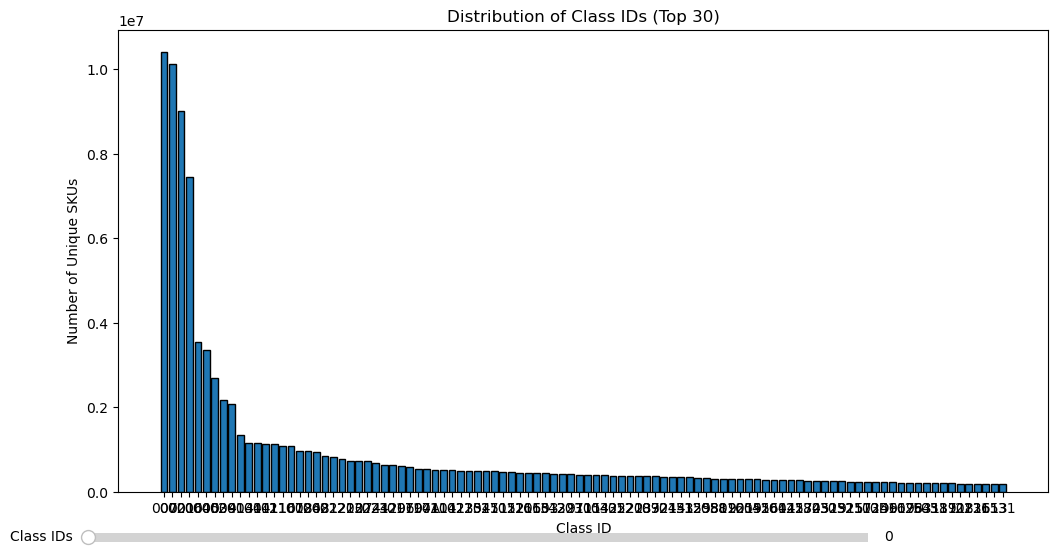

In [39]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

# Assuming 'original_df' is your original DataFrame
classid_counts = joined_df.groupby('classid')['sku'].count()

# Sort classids in descending order
classid_counts = classid_counts.sort_values(ascending=False)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the initial bar chart for the first 30 classids
bar_width = 0.8
bar_chart = ax.bar(classid_counts.index[:100], classid_counts.values[:100], width=bar_width, edgecolor='black')

# Add labels and title
ax.set_xlabel('Class ID')
ax.set_ylabel('Number of Unique SKUs')
ax.set_title('Distribution of Class IDs (Top 30)')

# Create a slider to adjust the displayed classids
ax_slider = plt.axes([0.1, 0.02, 0.65, 0.03])
slider = Slider(ax_slider, 'Class IDs', 0, len(classid_counts) - 30, valinit=0)

def update(val):
    start_index = int(slider.val)
    end_index = start_index + 30

    ax.clear()
    bar_chart = ax.bar(classid_counts.index[start_index:end_index], classid_counts.values[start_index:end_index],
                       width=bar_width, edgecolor='black')
    
    ax.set_xlabel('Class ID')
    ax.set_ylabel('Number of Unique SKUs')
    ax.set_title(f'Distribution of Class IDs (Class IDs {start_index + 1}-{end_index})')

    plt.draw()

slider.on_changed(update)

plt.show()

## Detailed Analysis of Changes of Discounts in one item

In [102]:
# Group by SKU and StoreID, then check the number of unique percent_discount values
change_over_time = joined_df.groupby(['sku', 'storeid'])['percent_discount'].nunique()

# Filter for combinations with more than 1 unique percent_discount value
changing_combinations = change_over_time[change_over_time > 5].index

# Display the SKU-StoreID combinations with changing percent_discount
changing_combinations

MultiIndex([(3581243, 7407),
            (4301183,  704),
            (5881183, 1904),
            (7490350, 7904),
            (9201784, 7004)],
           names=['sku', 'storeid'])

In [ ]:
# Filter rows with SKU-StoreID combinations in changing_combinations
analysis2 = joined_df[joined_df.set_index(['sku', 'storeid']).index.isin(changing_combinations)]

# Display the resulting DataFrame
print(analysis2.size)
analysis2.head()

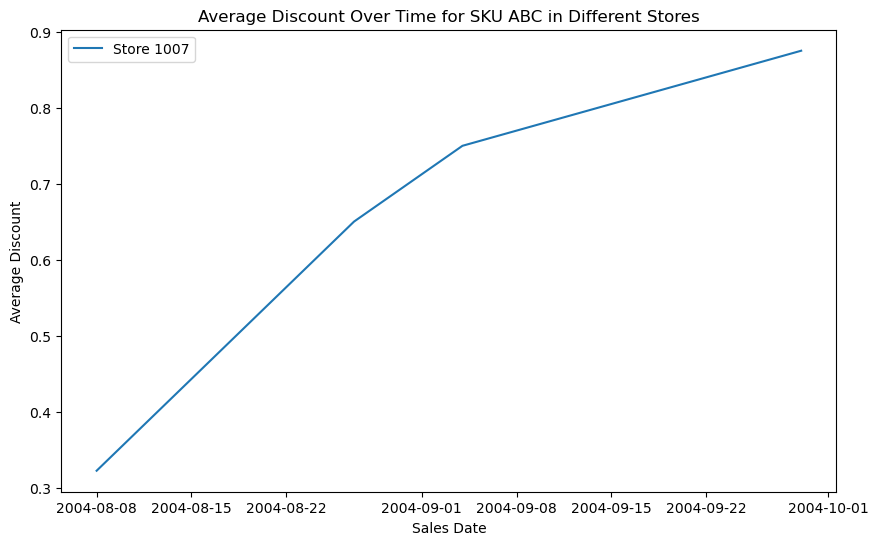

In [52]:
import matplotlib.pyplot as plt

# Step 1: Filter the DataFrame for the specific SKU "ABC"
filtered_df = analysis2[analysis2['sku'] == 4301183]
filtered_df = filtered_df[filtered_df['storeid'] == 704]

# Step 2: Group by "storeid" and "sales date", calculate the average of "discount"
grouped_df = filtered_df.groupby(['storeid', 'saledate'])['percent_discount'].mean().reset_index()

# Step 3: Plot the line chart
plt.figure(figsize=(10, 6))

for storeid in grouped_df['storeid'].unique():
    store_data = grouped_df[grouped_df['storeid'] == storeid]
    plt.plot(store_data['saledate'], store_data['percent_discount'], label=f'Store {storeid}')

plt.xlabel('Sales Date')
plt.ylabel('Average Discount')
plt.title('Average Discount Over Time for SKU ABC in Different Stores')
plt.legend()
plt.show()

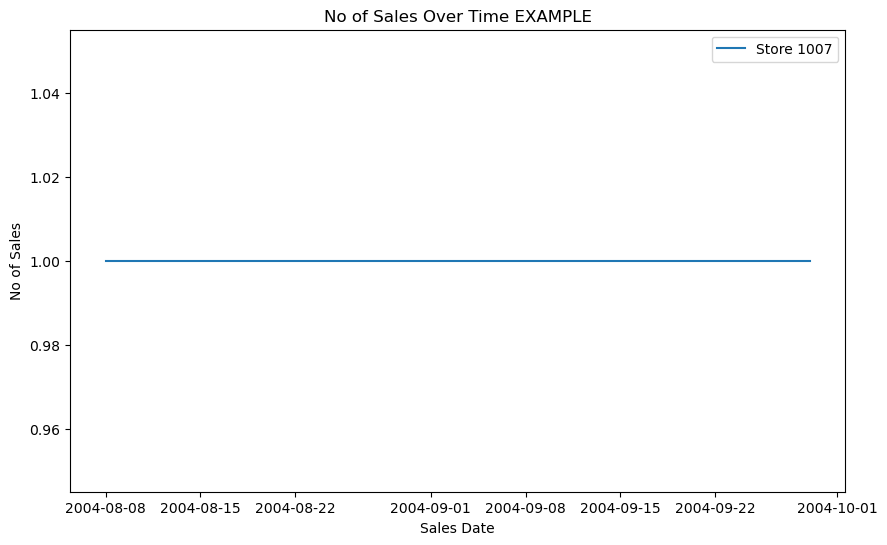

In [53]:
import matplotlib.pyplot as plt

# Step 1: Filter the DataFrame for the specific SKU "ABC"
filtered_df = analysis2[analysis2['sku'] == 4301183]
filtered_df = filtered_df[filtered_df['storeid'] == 704]

# Step 2: Group by "storeid" and "sales date", calculate the average of "discount"
grouped_df = filtered_df.groupby(['storeid', 'saledate'])['seq'].count().reset_index()

# Step 3: Plot the line chart
plt.figure(figsize=(10, 6))

for storeid in grouped_df['storeid'].unique():
    store_data = grouped_df[grouped_df['storeid'] == storeid]
    plt.plot(store_data['saledate'], store_data['seq'], label=f'Store {storeid}')

plt.xlabel('Sales Date')
plt.ylabel('No of Sales')
plt.title('No of Sales Over Time EXAMPLE')
plt.legend()
plt.show()

## Analysis Items not sold the entire time

In [56]:
no_of_days = joined_df['saledate'].nunique()
print(no_of_days)

389


In [60]:
# Calculate the number of unique days for each SKU
sku_unique_days = joined_df.groupby('sku')['saledate'].nunique()

# Identify SKUs with fewer unique days than overall no_of_days
skus_less_unique_days = sku_unique_days[sku_unique_days < (no_of_days - 60)]

# Calculate the percentage of SKUs falling into this category
percentage_skus_less_unique_days = (len(skus_less_unique_days) / len(sku_unique_days)) * 100

# Display the SKUs and percentage
print("SKUs with fewer unique days than overall no_of_days:")
print(skus_less_unique_days)

print("\nPercentage of SKUs falling into this category: {:.2f}%".format(percentage_skus_less_unique_days))


SKUs with fewer unique days than overall no_of_days:
sku
4          22
5          20
8           6
20          1
23          5
           ..
9999967     4
9999970     5
9999974    35
9999992     6
9999997    10
Name: saledate, Length: 707131, dtype: int64

Percentage of SKUs falling into this category: 99.15%


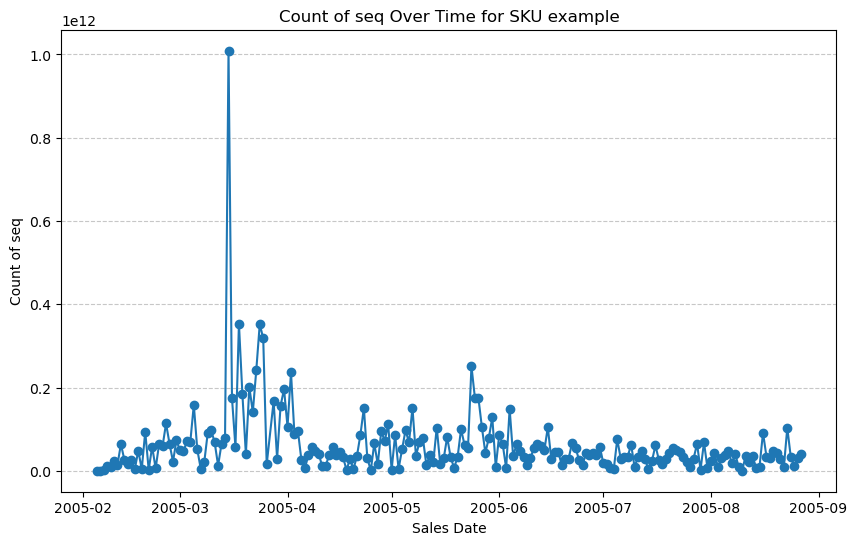

In [68]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Filter rows for the specific SKU
sku_example_data = joined_df[joined_df['sku'] == 9549158]

# Calculate the count of "seq" over time
count_seq_over_time = sku_example_data.groupby('saledate')['seq'].sum().reset_index()

# Plot the number (count) of "seq" over time
plt.figure(figsize=(10, 6))
plt.plot(count_seq_over_time['saledate'], count_seq_over_time['seq'], marker='o')

plt.xlabel('Sales Date')
plt.ylabel('Count of seq')

# Disable scientific notation on the y-axis
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=False))

plt.title('Count of seq Over Time for SKU example')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [63]:
# Filter rows for SKUs with fewer unique days than overall no_of_days
skus_less_unique_days_data = joined_df[joined_df['sku'].isin(skus_less_unique_days.index)]

# Calculate the overall revenue
overall_revenue = joined_df['retail'].sum()

# Calculate the revenue for SKUs with fewer unique days
revenue_skus_less_unique_days = skus_less_unique_days_data['retail'].sum()

# Calculate the percentage of overall revenue
percentage_revenue_skus_less_unique_days = (revenue_skus_less_unique_days / overall_revenue) * 100

# Display the percentage of overall revenue
print("Percentage of overall revenue accounted for by SKUs with fewer unique days: {:.2f}%".format(percentage_revenue_skus_less_unique_days))

Percentage of overall revenue accounted for by SKUs with fewer unique days: 76.78%


In [66]:
max_rev = skus_less_unique_days_data.groupby('sku')['retail'].sum().reset_index()
max_rev = max_rev.sort_values(by="retail", ascending = False)
max_rev.head()

,sku,retail
675575,9549158,1747510.0
186856,2637537,1333575.0
378228,5327384,1257719.5
399033,5618966,1238848.0
703963,9956667,1160510.0


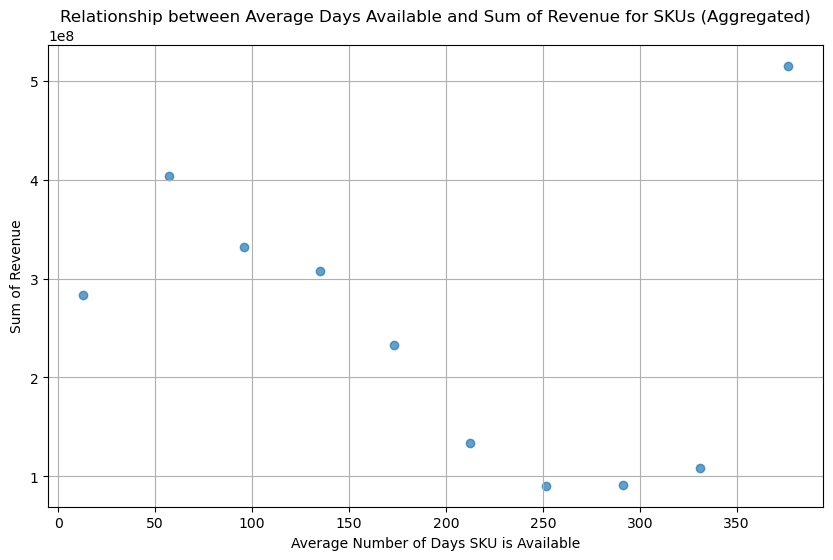

In [69]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the number of days a SKU is available in the data
sku_days_available = joined_df.groupby('sku')['saledate'].nunique()

# Calculate the sum of revenue for each SKU
sku_sum_revenue = joined_df.groupby('sku')['retail'].sum()

# Combine data into a DataFrame
df_combined = pd.DataFrame({'DaysAvailable': sku_days_available, 'SumRevenue': sku_sum_revenue})

# Create bins for the number of days available
bins = pd.cut(df_combined['DaysAvailable'], bins=10)

# Aggregate data within each bin
agg_data = df_combined.groupby(bins).agg({'DaysAvailable': 'mean', 'SumRevenue': 'sum'})

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(agg_data['DaysAvailable'], agg_data['SumRevenue'], alpha=0.7)

plt.xlabel('Average Number of Days SKU is Available')
plt.ylabel('Sum of Revenue')
plt.title('Relationship between Average Days Available and Sum of Revenue for SKUs (Aggregated)')
plt.grid(True)

plt.show()


In [88]:

# Calculate the sum of revenue for each SKU
sku_sum_revenue = joined_df.groupby('sku')['retail'].sum()

# Sort SKUs by sum of revenue in descending order
sorted_skus = sku_sum_revenue.sort_values(ascending=False).reset_index()

# Calculate cumulative sum of revenue
cumulative_sum = sorted_skus.cumsum()

In [89]:
cumulative_sum.head()

,sku,retail
0,4108011,6352542.50
1,7632037,12415641.50
2,13160386,17573422.20
3,17138397,21436291.45
4,19922393,24883115.95


In [93]:
max_revenue = cumulative_sum['retail'].max() / 2

In [96]:
sku_result_cumulative_sum = cumulative_sum[cumulative_sum.retail > max_revenue].head(1)
sku_result_cumulative_sum

,sku,retail
24119,120129064761,1.249274e+09


In [97]:
sku_result_cumulative_sum = cumulative_sum[cumulative_sum.retail > max_revenue].tail(1)
sku_result_cumulative_sum

,sku,retail
713170,3557563539430,2.498527e+09


In [101]:
# Percentage of sku that make up 50% of revenue
round(24119 / (713170 + 24119)* 100,2)

3.27

### Relationship btw classes and sku (most important)